# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

-----

## Getting Started
In this project, we will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, we will load visualization code that will be used later on in the project. The code cell below import this code which is required for our analysis.

In [1]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing our driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

### Observation
- During the simulation our agent is stationary. We can see that  "Agent not enforced to meet deadline" and dosen't performe any action. 
- In the next simulation driving agent is receiving positive (ex for staying at the red light) and negative rewards (for not moving at the green light).

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`.

- In the *`agent.py`* Python file there is 3 flags we can set:
    - learning = Whether the agent is expected to learn
    - epsilon = Random exploration factor
    - alpha = Learning factor

- In the *`environment.py`* Python file, act() function is called when an agent performs an action (in Environment class). 
- In the *`simulator.py`* Python file, render_text() is the non-GUI render display of the simulation and render() is the GUI render display of the simulation.
- In the *`planner.py`* Python file, next_waypoint() function consider the East-West direction first and then North-South.
   

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None` (do nothing), `'left'` (turn left), `right'` (turn right), or `'forward'` (go forward). For our first implementation, lets navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. 

Note that we have access to several class variables that will help us to write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, we can run the agent file and simulation briefly to confirm that our driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, we will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, we may disable the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. 

Once we have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials),  we can visualize the results. 

Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

Hint:
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.

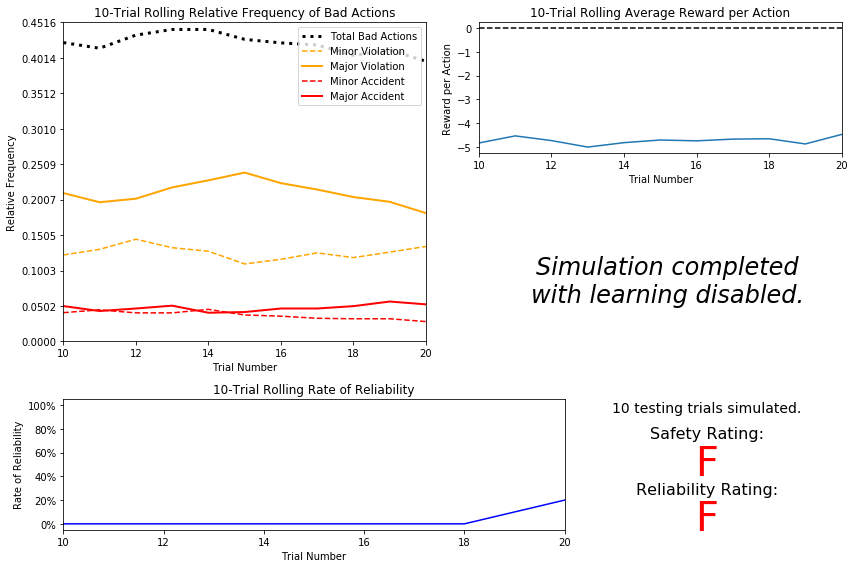

In [3]:
# Load the 'sim_no-learning' log file from the initial simulation results
import os
vs.plot_trials('sim_no-learning.csv')

Using the visualization above that was produced from our initial simulation lets make a few observations:


- Driving agent makes a lot of bad decisions at beginig of simulation, but at the end he starts to improve himself (total bad action goes down, especialy major violations) but it may be due to randomnes. Bad decisions caused around 0.05 of Minor and 0.05 of Major accindents. 
- Given that the agent is driving randomly the rate of reliability dosen't make sense, because the agent drives randomly and dosent have a "plan" to get to destination.
- Looking at the graph of Average Reward per Action, the agent got -5 on average par trial, he was heavily penalized because he was taking the wrong actions more often then the right actions. Also the learning is disabled.
- As the number of trials increases (looking at Rolling Rate of Reliability), the outcome of results dosen't change, because agent dosent learn yet, so the trials are independent.
- For the moment this SmartCab is higly unsafe and unreliable, it could be only used to get some chill sensation...

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

**Note:**
- 'deadline' is not appropriate for **safety** because adding it will make the possible states to big, but most importantly  the features that are most important to safety and efficiency are the "phisical inputs" - as they help avoiding collisions with other vehicles. The waypoint tells the smartcab which direction it should go at each intersection. Those are most important inputs for building states and try to keep it as small as possible. Also agent need to cros an intersection obeing the rules regardless of the deadline. Red light is a red light even if it has only one move left.

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if we expect the driving agent to learn a **policy** for each state, we would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, lets consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

Given what we know about the environment and how it is simulated, we will have the following combinations of features to calculate:

- 2 lights (red, green)
- 4 oncoming car presents/directions (none, left, right, forward)
- 4 left car presents/directions (none, left, right, forward 
- 4 right car presents/directions (none, left, right, forward
- 3 waypoint (or directions to go)

... and if we multiply all together the total possible states will be 384.

### Update the Driving Agent State
For our second implementation, let's navigate to the `'build_state()'` agent function and set the `'state'` variable to a tuple of all the features necessary for Q-Learning. 

**Note:**  Confirm if driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation. Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the iterative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, we will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that we are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, we will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, we will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

**Note:**
If you have difficulty getting this implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that we understand what each flag does and how it affects the simulation! 

Once we have successfully completed the initial Q-Learning simulation, we can run the code cell below to visualize the results. 

**Note:**
Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

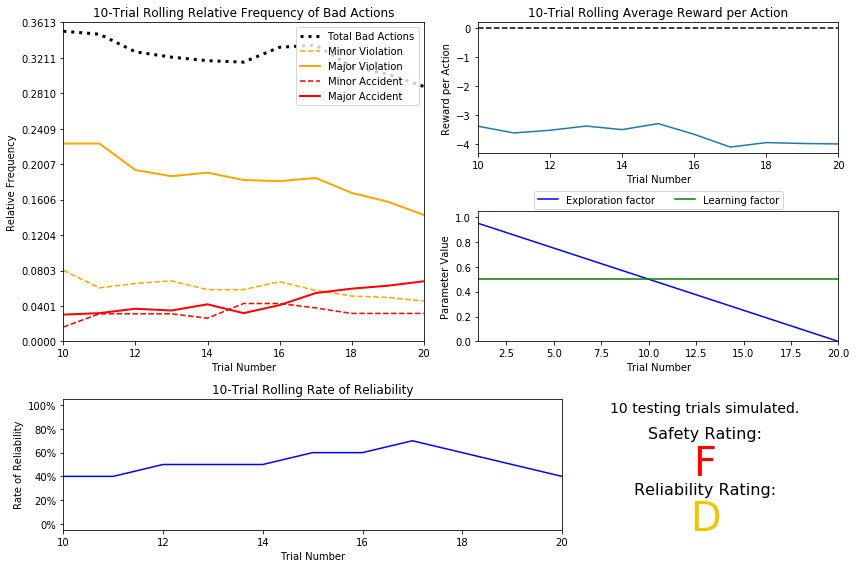

In [6]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

Using the visualization above that was produced from our default Q-Learning simulation let's make some observations about the driving agent:

- We can see that our agent is now starting to learn and improve himself by a very little. But the number of trials is too small to learn the states and the action/reward.
- Driving agent require 20 training trials before testing (the default value), that number make sense given the epsilon is decaying too fast at each stape.
- The exploration factor is accurately represented in the parameters panel - it's a linear function and we clearly see it in our graph.
- Looking at the graph of Rolling Frequency of Bad Actions we can see as the number of training trials increases the number of bad actions stays the same. The average reward also dosen't change and stays around -4 per action.
- Safety and reliability rating are F and D respectivly for this agent, it's not a big improvement over the default agent. And even the D note can be attributed to the "chance".

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, we will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use our Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent we are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of our choice for $\epsilon$ (the exploration factor). Note that whichever function we use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$

**Note:**
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. 

Once we have successfully completed the improved Q-Learning simulation, let's run the code cell below to visualize the results. 

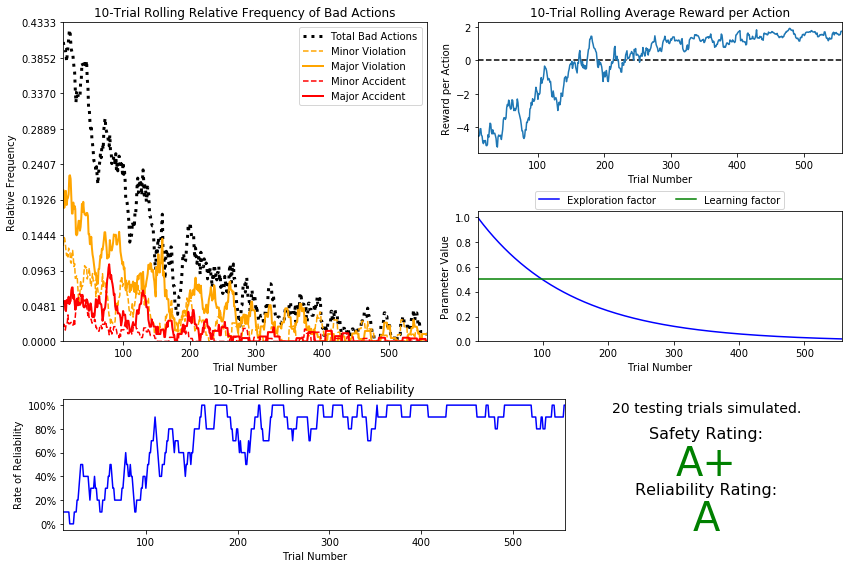

In [22]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

Using the visualization above that was produced from our improved Q-Learning simulation, let's make a final analysis and  observations about the improved driving agent 

- We  have finally made an agent who learns. It's a big improvement. We can see from the plot above how agent improves himself with each step.
- A simple decaying function epsilon * 0.993 was used because the given priviously formula ϵt+1=ϵt−0.05 didn't work quite well, new decaying function gave us A+ and A. Also we could reach A+ A+ 0.999 but it takes more than 3000 trials.
- Driving agent requires 600 training trials before testing, that number make sense given the epsilon-tolerance at each stape.
- 0.02 was used for tollerance and 0.5 for alpha in final model, other values for tolerance were used too but either agent was starting too early the testing process or it was taking too much time to train without any important improvement. 
- Looking at the graph of Rolling Frequency of Bad Actions we can see as the number of training trials increased the number of bad actions decrease (in the same graph of default agent the number of bad actions were the same). The average reward increases, we can almost draw a log line to represent a tendency.
- Safety and reliability rating are A+ and A respectivly for this agent, it's a big improvement over our default agent.

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Some observations
1 The best set of instructions in this environment will follow closely the actual driving rules - if it's red you should stop and wait for a green light. But in USA you can turn right if there is no car comming from the left, here is an example from our Q-table:

- (('light', 'red'), ('oncoming', None), ('right', 'right'), ('left', None), 'right')
 -- forward : -9.35
 -- None : 0.00
 -- right : 2.16
 -- left : -5.23

 
 
3 In real life this make a perfect sens, you can move forward and right, but because there is a car comming up front you'll have an accindent if you turn left:

- (('light', 'green'), ('oncoming', 'forward'), ('right', None), ('left', 'left'), 'left')
 -- forward : 1.15
 -- None : -2.58
 -- right : 0.36
 -- left : -14.69

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propagating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**
- I think the probleme with  enviroment is the randomnese in the "world", as each intersection is randomly generated they independant of each other - so we can't choose the best route because of it. The environment variables are randomly set up, the current state could't be exactly the same as what it was one time step before, so we can end up including incorrect future rewards in the policies.
- The seconde probleme maybe be explained simply by the following: smartcab dosen't know his position on the map - driving without GPS.